In [1]:
from dataloader import NetCDFSR, xr_standardize_field
import xarray as xr
import numpy as np
import glob
import torch

from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.decomposition import PCA

import matplotlib.pyplot as plt
from models import Generator, Discriminator

%load_ext autoreload
%autoreload 2

torch.cuda.empty_cache()

In [2]:
dataroot = "data/interim_2000-10-01_to_2013-09-30.nc"
device = torch.device("cuda:0" if (torch.cuda.is_available()) else "cpu")

target = '10UV_GDS4_SFC'
# uncropped = xr.open_mfdataset(glob.glob(dataroot), combine='by_coords')
# uncropped[target] = xr.ufuncs.hypot(uncropped['10U_GDS4_SFC'], uncropped['10V_GDS4_SFC'])
# xarr = uncropped[target][:30, ...]
# xarr = xr_standardize_field(xarr)
uncropped = xr.open_dataset(dataroot)#[:, :, :18000]
sfc = xr.open_dataset("sfc_roughness.nc")

In [3]:
uncropped

<xarray.Dataset>
Dimensions:    (latitude: 54, longitude: 110, time: 18992)
Coordinates:
  * longitude  (longitude) float32 -139.1 -138.3 -137.6 ... -58.8 -58.05 -57.3
  * latitude   (latitude) float32 57.89 57.14 56.39 55.64 ... 19.64 18.89 18.14
  * time       (time) datetime64[ns] 2000-10-01 ... 2013-09-30T18:00:00
Data variables:
    u10        (time, latitude, longitude) float32 ...
    v10        (time, latitude, longitude) float32 ...
Attributes:
    Conventions:  CF-1.6
    history:      2021-03-31 05:45:14 GMT by grib_to_netcdf-2.21.0: grib_to_n...

In [4]:
# assert np.abs(xr_standardize_field(xarr).mean()) < 10E-5
# assert np.abs(xr_standardize_field(xarr).std() - 1.0) < 10E-5
uncropped["u10"].shape
sfc

<xarray.Dataset>
Dimensions:    (latitude: 54, longitude: 110, time: 18992)
Coordinates:
  * longitude  (longitude) float32 -139.1 -138.3 -137.6 ... -58.8 -58.05 -57.3
  * latitude   (latitude) float32 57.89 57.14 56.39 55.64 ... 19.64 18.89 18.14
  * time       (time) datetime64[ns] 2000-10-01 ... 2013-09-30T18:00:00
Data variables:
    sr         (time, latitude, longitude) float32 ...
Attributes:
    Conventions:  CF-1.6
    history:      2021-04-01 21:54:29 GMT by grib_to_netcdf-2.21.0: grib_to_n...

In [5]:
midx = uncropped['u10'].values.shape[2] // 2
midy = uncropped['v10'].values.shape[1] // 2
assert midx >= 2*midy
midx, midy

(55, 27)

In [6]:
u10 = uncropped['u10'][:18000, ...]
v10 = uncropped['v10'][:18000, ...]
sr = sfc['sr'][:18000, ...]
u10 = xr_standardize_field(u10)[:, :, midx-midy:midx+midy][..., 1:-1, 1:-1]
v10 = xr_standardize_field(v10)[:, :, midx-midy:midx+midy][..., 1:-1, 1:-1]
sr =  xr_standardize_field(sr)[:, :, midx-midy:midx+midy][..., 1:-1, 1:-1]

In [7]:
u10.shape

(18000, 52, 52)

In [8]:
u10.shape

(18000, 52, 52)

In [9]:
fine = uncropped['u10'][:, :, midx-midy:midx+midy]

In [10]:
sx, sy = 4, 4
coarse_u10 = u10.coarsen(longitude=sx).mean().coarsen(latitude=sy).mean()
coarse_v10 = v10.coarsen(longitude=sx).mean().coarsen(latitude=sy).mean()
coarse_sr = sr.coarsen(longitude=sx).mean().coarsen(latitude=sy).mean()

In [11]:
coarse_u10.shape, coarse_sr.shape

((18000, 13, 13), (18000, 13, 13))

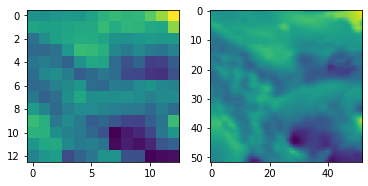

In [12]:
fig,ax = plt.subplots(1, 2)
ax[0].imshow(coarse_u10[18, ...])
ax[1].imshow(u10[18, ...])

In [13]:
coarse = np.stack([coarse_u10, coarse_v10, coarse_sr], axis=1)
fine = np.stack([u10, v10, sr], axis=1)

In [14]:
fine.shape, u10.shape, 52*52

((18000, 3, 52, 52), (18000, 52, 52), 2704)

In [15]:
# PCA
ncomp = 50
fine_pca_u10 = np.array(u10).reshape(u10.shape[0], u10.shape[1]*u10.shape[2])
pca = PCA(n_components=ncomp)
pca.fit(fine_pca_u10)
fine_sp_basis_u10 = pca.components_.reshape(ncomp, u10.shape[1]*u10.shape[2])

fine_pca_v10 = np.array(v10).reshape(v10.shape[0], v10.shape[1]*v10.shape[2])
pca = PCA(n_components=ncomp)
pca.fit(fine_pca_v10)
fine_sp_basis_v10 = pca.components_.reshape(ncomp, v10.shape[1]*v10.shape[2])

fine_sp_basis = np.stack([fine_sp_basis_u10, fine_sp_basis_v10], axis=1)

In [16]:
coarse_u10.shape

(18000, 13, 13)

In [17]:
# PCA Coarse
ncomp = 169
coarse_pca_u10 = np.array(coarse_u10).reshape(coarse_u10.shape[0], coarse_u10.shape[1]*coarse_u10.shape[2])
pca_coarse = PCA(n_components=ncomp)
pca_coarse.fit(coarse_pca_u10)
coarse_sp_basis_u10 = pca_coarse.components_.reshape(ncomp, coarse_u10.shape[1]*coarse_u10.shape[2])

coarse_pca_v10 = np.array(coarse_v10).reshape(coarse_v10.shape[0], coarse_v10.shape[1]*coarse_v10.shape[2])
pca_coarse = PCA(n_components=ncomp)
pca_coarse.fit(coarse_pca_v10)
coarse_sp_basis_v10 = pca_coarse.components_.reshape(ncomp, coarse_v10.shape[1]*coarse_v10.shape[2])

coarse_sp_basis = np.stack([coarse_sp_basis_u10, coarse_sp_basis_v10], axis=1)

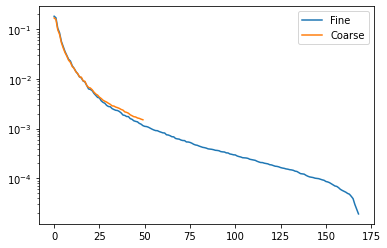

In [18]:
plt.plot(range(pca_coarse.explained_variance_ratio_.size), pca_coarse.explained_variance_ratio_, label="Fine")
plt.plot(range(pca.explained_variance_ratio_.size), pca.explained_variance_ratio_, label="Coarse")
plt.semilogy()
plt.legend()

In [19]:
fine_t = torch.from_numpy(np.array(fine))
coarse_t = torch.from_numpy(np.array(coarse))
pcas_t = torch.from_numpy(fine_sp_basis)

In [20]:
dataset = NetCDFSR(
    fine_t,
    coarse_t,
    pcas_t,
    device=device
)

dataloader = torch.utils.data.DataLoader(
    dataset=dataset,
    batch_size=64,
    shuffle=True
)

In [21]:
real_batch, real_cbatch, pcas = next(iter(dataloader))
fixed = {"coarse": real_cbatch[:1, ...], "fine": real_batch[:1, ...]}
pcas.size()
fixed["coarse"].shape

torch.Size([1, 3, 13, 13])

In [22]:
# pcas[:1, ...].size(), pcas[:1, ...].transpose(2, 1).size()
# X = pcas[0, ...]#pcas[:1, ...]#.transpose(2, 1)
# # torch.matmul(real, X).size()
# # X.unsqueeze(0).transpose(2, 1).size(), real.unsqueeze(2).transpose(2, 1).size()#transpose(-1, -2).unsqueeze(1).size()
# real = torch.reshape(
#     real_batch, 
#     (real_batch.size(0), real_batch.size(1), real_batch.size(2)*real_batch.size(3))
# )

# A = real.unsqueeze(2).unsqueeze(1)#.transpose(-1, -2)
# B = X.unsqueeze(-1)#.transpose(3, 2)#.transpose(-1, -2)
# print(A.size())
# print(B.size())
# proj_real = torch.matmul(A, B)
# proj_fake = torch.matmul(A, B)

# coefficient_loss = torch.nn.L1Loss().to(device)
# coefficient_loss(proj_real, proj_fake).item()

In [23]:
# # real_batch.size(), pcas[:1, :, :1, :].size()
# real = torch.reshape(
#     real_batch, 
#     (real_batch.size(0), real_batch.size(1), real_batch.size(2)*real_batch.size(3))
# )[:, :1, :]
# real.size()
# torch.matmul(real, X.transpose(3, 2))#.transpose(0, 1)

In [24]:
# real = torch.reshape(
#     real_batch, 
#     (real_batch.size(0), real_batch.size(1), real_batch.size(2)*real_batch.size(3))
# )

# fake = torch.reshape(
#     real_batch, 
#     (real_batch.size(0), real_batch.size(1), real_batch.size(2)*real_batch.size(3))
# )

# projected_real = torch.matmul(real, pcas.transpose(2, 1)).transpose(0, 1)
# projected_fake = torch.matmul(fake, pcas.transpose(2, 1)).transpose(0, 1)

# projected_real.size()

# closs = coefficient_loss(projected_fake, projected_real).item()

In [25]:
# real = torch.reshape(
#     real_batch, 
#     (real_batch.size(0), real_batch.size(1), real_batch.size(2)*real_batch.size(3))
# )

# fake = torch.reshape(
#     real_batch, 
#     (real_batch.size(0), real_batch.size(1), real_batch.size(2)*real_batch.size(3))
# )

# projected_real = torch.matmul(real, pcas[:1, ...].transpose(3, 2)).transpose(0, 1)
# projected_fake = torch.matmul(fake, pcas[:1, ...].transpose(3, 2)).transpose(0, 1)

# projected_real.size()
# (projected_fake/torch.flip(torch.arange(1, projected_real.size(-1)+1), (0, ))).size()

In [26]:
from models import Generator, Discriminator, patch_discriminator

# discriminator = patch_discriminator().to(device)#Discriminator(7, 14, 1).to(device)
discriminator = Discriminator(7, 14, 3).to(device)
generator = Generator(14, 56, 3).to(device)
lr = 0.00025

In [27]:
G_optimizer = torch.optim.Adam(generator.parameters(), lr=lr, betas=(.9, .99))
D_optimizer = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(.9, .99))

# Set up trainer
from training import Trainer
trainer = Trainer(generator, discriminator, G_optimizer, D_optimizer,
                  use_cuda=torch.cuda.is_available(), print_every=500, save_every=500, device=device)

# Train model for 200 epochs
trainer.train(
    dataloader,
    epochs=450,
    fixed=fixed,
    save_training_gif=True
)


Epoch 1
Iteration 1
D: 0.00015374552458524704
GP: 9.996695518493652
Gradient norm: 0.00016524667444173247
cuda memory: 89833472

Epoch 2
Iteration 1
D: 119.18263244628906
GP: 37.437294006347656
Gradient norm: 2.930837631225586
cuda memory: 1404894720
G: 12.54687213897705
Content loss: 0.5699169635772705
EOF:  0.8594968914985657
Divloss:  1.821079969406128

Epoch 3
Iteration 1
D: 107.1165542602539
GP: 34.46397399902344
Gradient norm: 2.8548922538757324
cuda memory: 1388450304
G: 6.756309986114502
Content loss: 0.37751609086990356
EOF:  0.3301680386066437
Divloss:  1.641769528388977

Epoch 4
Iteration 1
D: 75.4891128540039
GP: 22.881498336791992
Gradient norm: 2.5123629570007324
cuda memory: 1385753088
G: 4.897566795349121
Content loss: 0.31348878145217896
EOF:  0.1842716485261917
Divloss:  1.4729934930801392

Epoch 5
Iteration 1
D: 55.9483757019043
GP: 15.93857192993164
Gradient norm: 2.2622337341308594
cuda memory: 1398704640
G: 4.5147705078125
Content loss: 0.28494757413864136
EOF:  

In [57]:
torch.clear_autocast_cache()